In [1]:
import os
from pathlib import Path
from monarch.utils.path_utils import use_path

base_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

# Use relative paths from the base directory
config_path = str(base_dir / "configs/datasets/nuplan/8cams_undistorted.yaml")
checkpoint_path = str(base_dir / "output/master-project/run_omnire_undistorted_8cams_0")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

# Function to get ego vehicle position from the ego pose matrix
def get_ego_position_info(ego_pose_matrix):
    # Extract position from the translation part of the matrix (last column)
    position = ego_pose_matrix[:3, 3]
    
    # Extract rotation as quaternion
    rotation_matrix = ego_pose_matrix[:3, :3]
    # Create quaternion from rotation matrix
    quat = Quaternion(matrix=rotation_matrix)
    # Extract yaw (heading) from quaternion as Euler angle
    yaw = quat.yaw_pitch_roll[0]
    
    return {
        "position": position,
        "x": position[0],
        "y": position[1],
        "z": position[2],
        "quaternion": quat,
        "heading": yaw,
        "heading_degrees": np.degrees(yaw)
    }

# Specify the scene directory and first frame index
def print_ego_starting_position(scene_dir, frame_idx=0):
    # Load the ego pose matrix for the first frame
    ego_pose_path = os.path.join(scene_dir, "ego_pose", f"{frame_idx:03d}.txt")
    
    if not os.path.exists(ego_pose_path):
        print(f"Error: Ego pose file not found at {ego_pose_path}")
        return None
    
    try:
        # Load the 4x4 transformation matrix
        ego_pose_matrix = np.loadtxt(ego_pose_path)
        
        # Get position and orientation information
        ego_info = get_ego_position_info(ego_pose_matrix)
        
        # Print the starting position information
        print("=== Ego Vehicle Starting Position (Frame 0) ===")
        print(f"Position (x, y, z): ({ego_info['x']:.3f}, {ego_info['y']:.3f}, {ego_info['z']:.3f})")
        print(f"Heading: {ego_info['heading']:.3f} rad, {ego_info['heading_degrees']:.2f}°")
        print(f"Quaternion (w, x, y, z): ({ego_info['quaternion'].w:.3f}, {ego_info['quaternion'].x:.3f}, {ego_info['quaternion'].y:.3f}, {ego_info['quaternion'].z:.3f})")
        print("Full transformation matrix:")
        print(ego_pose_matrix)
        
        # Return the information for further use if needed
        return ego_info
    except Exception as e:
        print(f"Error reading ego pose file: {e}")
        return None

In [3]:
# List available scenes in the NuPlan dataset
import glob

# Path to the NuPlan processed data directory
nuplan_data_dir = os.path.join(base_dir, "drivestudio/data/nuplan/processed/mini")

# Check if the directory exists
if os.path.exists(nuplan_data_dir):
    # List all scene directories
    scene_dirs = glob.glob(os.path.join(nuplan_data_dir, "*"))
    scene_dirs = [d for d in scene_dirs if os.path.isdir(d)]
    
    print(f"Found {len(scene_dirs)} scenes in NuPlan dataset:")
    for i, scene_dir in enumerate(scene_dirs):
        print(f"{i+1}. {os.path.basename(scene_dir)}")
else:
    print(f"NuPlan data directory not found at {nuplan_data_dir}")
    print("Please update the path to point to your NuPlan processed data location.")

Found 6 scenes in NuPlan dataset:
1. 2021.05.12.22.00.38_veh-35_01008_01518
2. 2021.05.12.22.28.35_veh-35_00620_01164
3. 2021.05.12.23.36.44_veh-35_02035_02387
4. 2021.05.12.23.36.44_veh-35_01133_01535
5. 2021.05.25.14.16.10_veh-35_01690_02183
6. 2021.05.12.23.36.44_veh-35_00152_00504


Analyzing scene: 2021.05.12.22.00.38_veh-35_01008_01518

=== Ego Vehicle Starting Position (Frame 0) ===
Position (x, y, z): (664647.261, 3999250.843, 606.740)
Heading: -2.066 rad, -118.35°
Quaternion (w, x, y, z): (-0.512, 0.001, 0.012, 0.859)
Full transformation matrix:
[[-4.74875320e-01  8.79989872e-01 -1.05477810e-02  6.64647261e+05]
 [-8.79924247e-01 -4.74566619e-01  2.28000857e-02  3.99925084e+06]
 [ 1.50582198e-02  2.01084462e-02  9.99684400e-01  6.06740224e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


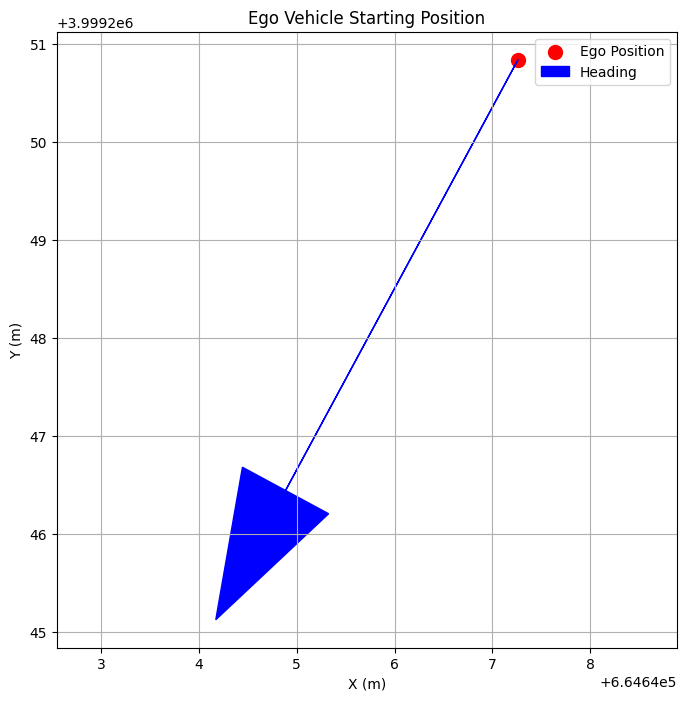

In [4]:
# Analyze the ego position of the first scene (or specify a different scene index)
scene_index = 0  # Change this to analyze a different scene

if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    selected_scene = scene_dirs[scene_index]
    print(f"Analyzing scene: {os.path.basename(selected_scene)}\n")
    
    # Print ego starting position for the selected scene
    ego_info = print_ego_starting_position(selected_scene)
    
    # Optionally, visualize the ego position in a 2D plot
    if ego_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(ego_info['x'], ego_info['y'], color='red', s=100, marker='o', label='Ego Position')
        
        # Draw an arrow indicating the heading direction
        arrow_length = 5.0  # adjust as needed
        dx = arrow_length * np.cos(ego_info['heading'])
        dy = arrow_length * np.sin(ego_info['heading'])
        plt.arrow(ego_info['x'], ego_info['y'], dx, dy, head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Heading')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Starting Position')
        plt.legend()
        plt.show()
else:
    print("Cannot analyze ego position: No valid scene found.")


Calculating ego movement in scene: 2021.05.12.22.00.38_veh-35_01008_01518

=== Ego Vehicle Movement ===
From frame 0 to 50:
Start position: (664647.261, 3999250.843, 606.740)
End position: (664627.840, 3999214.200, 607.244)
Delta position (x, y, z): (-19.421, -36.643, 0.504)
Distance traveled: 41.472 m
Delta heading: 0.006 rad, 0.32°


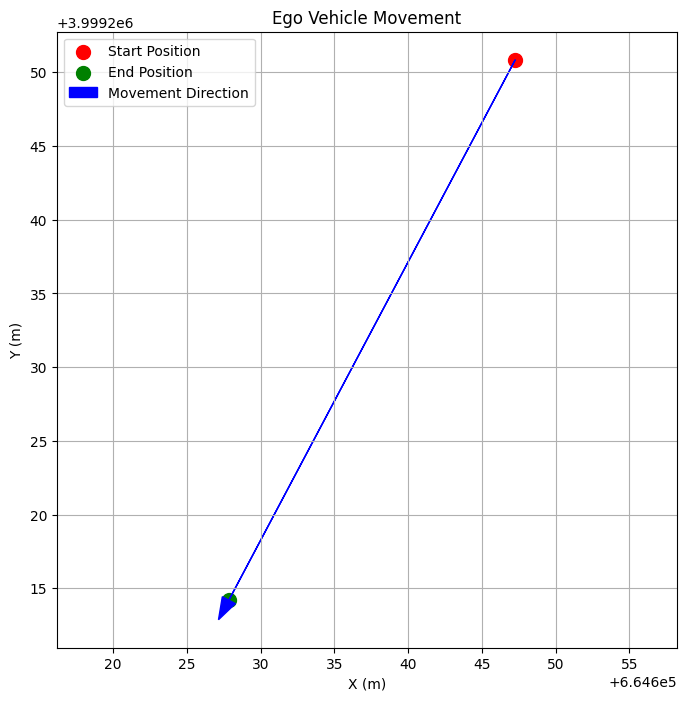

In [5]:
def calculate_ego_movement(scene_dir, start_frame=0, end_frame=50):
    """
    Calculate and visualize the movement of ego vehicle between two frames.
    
    Args:
        scene_dir: Directory containing the scene data
        start_frame: Index of the starting frame (default: 0)
        end_frame: Index of the ending frame (default: 1)
    
    Returns:
        A dictionary containing the movement information
    """
    # Load the ego pose matrices for both frames
    start_pose_path = os.path.join(scene_dir, "ego_pose", f"{start_frame:03d}.txt")
    end_pose_path = os.path.join(scene_dir, "ego_pose", f"{end_frame:03d}.txt")
    
    if not os.path.exists(start_pose_path) or not os.path.exists(end_pose_path):
        print(f"Error: Ego pose files not found")
        return None
    
    try:
        # Load the transformation matrices
        start_pose_matrix = np.loadtxt(start_pose_path)
        end_pose_matrix = np.loadtxt(end_pose_path)
        
        # Get position and orientation information
        start_info = get_ego_position_info(start_pose_matrix)
        end_info = get_ego_position_info(end_pose_matrix)
        
        # Calculate deltas
        delta_x = end_info['x'] - start_info['x']
        delta_y = end_info['y'] - start_info['y']
        delta_z = end_info['z'] - start_info['z']
        delta_heading = end_info['heading'] - start_info['heading']
        # Normalize heading delta to be within [-π, π]
        delta_heading = (delta_heading + np.pi) % (2 * np.pi) - np.pi
        
        # Calculate elapsed time if timestamps are available
        # This would require accessing the timestamp information from the data
        
        # Calculate distance traveled
        distance = np.sqrt(delta_x**2 + delta_y**2)
        
        movement_info = {
            'start_frame': start_frame,
            'end_frame': end_frame,
            'start_position': (start_info['x'], start_info['y'], start_info['z']),
            'end_position': (end_info['x'], end_info['y'], end_info['z']),
            'delta_position': (delta_x, delta_y, delta_z),
            'delta_heading': delta_heading,
            'distance': distance,
            'start_info': start_info,
            'end_info': end_info
        }
        
        # Print the movement information
        print("=== Ego Vehicle Movement ===")
        print(f"From frame {start_frame} to {end_frame}:")
        print(f"Start position: ({start_info['x']:.3f}, {start_info['y']:.3f}, {start_info['z']:.3f})")
        print(f"End position: ({end_info['x']:.3f}, {end_info['y']:.3f}, {end_info['z']:.3f})")
        print(f"Delta position (x, y, z): ({delta_x:.3f}, {delta_y:.3f}, {delta_z:.3f})")
        print(f"Distance traveled: {distance:.3f} m")
        print(f"Delta heading: {delta_heading:.3f} rad, {np.degrees(delta_heading):.2f}°")
        
        return movement_info
    
    except Exception as e:
        print(f"Error calculating ego movement: {e}")
        return None

# Example usage of the calculate_ego_movement function

if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    selected_scene = scene_dirs[scene_index]
    print(f"\nCalculating ego movement in scene: {os.path.basename(selected_scene)}\n")
    
    # Calculate ego movement between the first two frames
    movement_info = calculate_ego_movement(selected_scene, start_frame=0, end_frame=50)
    
    # Optionally visualize the movement
    if movement_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(movement_info['start_position'][0], movement_info['start_position'][1], color='red', s=100, marker='o', label='Start Position')
        plt.scatter(movement_info['end_position'][0], movement_info['end_position'][1], color='green', s=100, marker='o', label='End Position')
        
        # Draw an arrow indicating the movement direction
        plt.arrow(movement_info['start_position'][0], movement_info['start_position'][1],
                  movement_info['delta_position'][0], movement_info['delta_position'][1],
                  head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Movement Direction')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Movement')
        plt.legend()
        plt.show()
else:
    print("Cannot calculate ego movement: No valid scene found.")


Calculating agent movement in scene: 2021.05.12.22.00.38_veh-35_01008_01518

=== Agent 70026757511859bc Movement ===
From frame 0 to 1:
Start position: (664652.441, 3999247.395, 607.524)
End position: (664652.184, 3999246.902, 607.537)
Delta position (x, y, z): (-0.257, -0.493, 0.013)
Distance traveled: 0.556 m
Delta heading: 0.001 rad, 0.05°


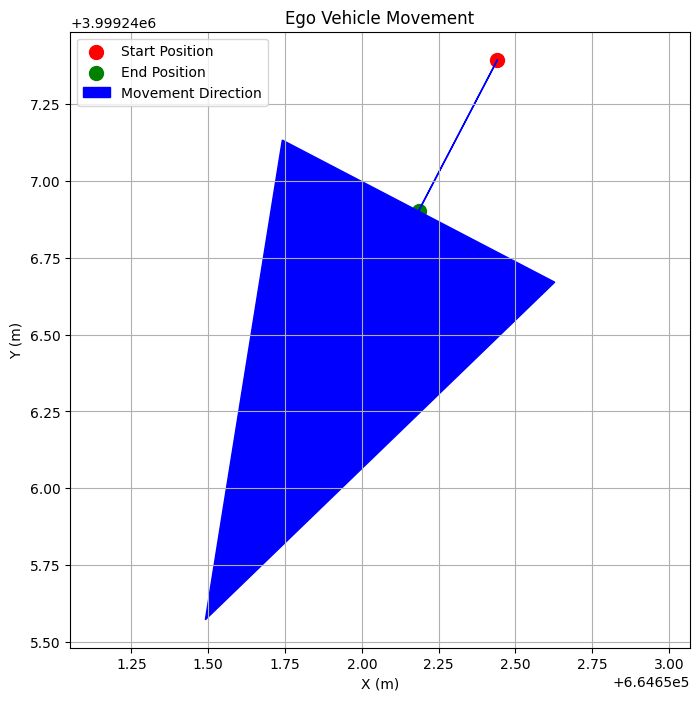

In [6]:
import os
import json

def calculate_agent_movement(scene_dir, agent_id, start_frame=0, end_frame=1):
    """
    Calculate the movement of a specific agent/vehicle between two frames.
    
    Args:
        scene_dir: Path to the scene directory
        agent_id: ID of the agent to track (as a string)
        start_frame: Starting frame number (default 0)
        end_frame: Ending frame number (default 1)
    
    Returns:
        Dictionary containing movement information or None if error occurs
    """
    try:
        # Load instances_info from the scene directory
        instances_info_path = os.path.join(scene_dir, "instances", "instances_info.json")
        if not os.path.exists(instances_info_path):
            raise FileNotFoundError(f"instances_info.json not found at {instances_info_path}")
        
        with open(instances_info_path, 'r') as f:
            instances_info = json.load(f)
        
        # Initialize movement info dictionary
        movement_info = {
            'start_position': None,
            'end_position': None,
            'delta_position': None,
            'distance': None,
            'delta_heading': None
        }
        
        # Find the agent by searching through all instances
        agent_data = None
        for instance_key, instance_data in instances_info.items():
            if instance_data.get('id') == agent_id:
                agent_data = instance_data
                break
        
        if agent_data is None:
            raise ValueError(f"Agent with ID {agent_id} not found in instances_info")
        
        frame_annotations = agent_data['frame_annotations']
        
        # Check if both frames are available for this agent
        if start_frame not in frame_annotations['frame_idx'] or end_frame not in frame_annotations['frame_idx']:
            raise ValueError(f"Agent {agent_id} not present in both frames")
        
        # Get indices for the start and end frames
        start_idx = frame_annotations['frame_idx'].index(start_frame)
        end_idx = frame_annotations['frame_idx'].index(end_frame)
        
        # Extract transformation matrices
        start_transform = np.array(frame_annotations['obj_to_world'][start_idx]).reshape(4, 4)
        end_transform = np.array(frame_annotations['obj_to_world'][end_idx]).reshape(4, 4)
        
        # Extract positions (translation part of the transformation matrix)
        start_pos = start_transform[:3, 3]
        end_pos = end_transform[:3, 3]
        
        # Calculate deltas
        delta_x = end_pos[0] - start_pos[0]
        delta_y = end_pos[1] - start_pos[1]
        delta_z = end_pos[2] - start_pos[2]
        
        # Calculate distance traveled
        distance = np.sqrt(delta_x**2 + delta_y**2 + delta_z**2)
        
        # Calculate heading change
        # Extract rotation matrices
        start_rotation = start_transform[:3, :3]
        end_rotation = end_transform[:3, :3]
        
        # Convert to quaternions for easier heading extraction
        start_quat = Quaternion(matrix=start_rotation)
        end_quat = Quaternion(matrix=end_rotation)
        
        # Extract yaw (heading) from quaternions
        start_heading = start_quat.yaw_pitch_roll[0]
        end_heading = end_quat.yaw_pitch_roll[0]
        
        # Calculate heading change and normalize to [-pi, pi]
        delta_heading = end_heading - start_heading
        delta_heading = (delta_heading + np.pi) % (2 * np.pi) - np.pi
        
        # Populate movement info
        movement_info['start_position'] = start_pos
        movement_info['end_position'] = end_pos
        movement_info['delta_position'] = (delta_x, delta_y, delta_z)
        movement_info['distance'] = distance
        movement_info['delta_heading'] = delta_heading
        
        # Print the movement information
        print(f"=== Agent {agent_id} Movement ===")
        print(f"From frame {start_frame} to {end_frame}:")
        print(f"Start position: ({start_pos[0]:.3f}, {start_pos[1]:.3f}, {start_pos[2]:.3f})")
        print(f"End position: ({end_pos[0]:.3f}, {end_pos[1]:.3f}, {end_pos[2]:.3f})")
        print(f"Delta position (x, y, z): ({delta_x:.3f}, {delta_y:.3f}, {delta_z:.3f})")
        print(f"Distance traveled: {distance:.3f} m")
        print(f"Delta heading: {delta_heading:.3f} rad, {np.degrees(delta_heading):.2f}°")
        
        return movement_info
    
    except Exception as e:
        print(f"Error calculating agent movement: {e}")
        return None
    
if os.path.exists(nuplan_data_dir) and len(scene_dirs) > scene_index:
    agent_token = "70026757511859bc"
    # agent_token = "b582d95cb714544d"
    selected_scene = scene_dirs[scene_index]
    print(f"\nCalculating agent movement in scene: {os.path.basename(selected_scene)}\n")
    
    # Calculate ego movement between the first two frames
    movement_info = calculate_agent_movement(selected_scene, agent_token, start_frame=0, end_frame=1)
    
    # Optionally visualize the movement
    if movement_info:
        plt.figure(figsize=(8, 8))
        plt.scatter(movement_info['start_position'][0], movement_info['start_position'][1], color='red', s=100, marker='o', label='Start Position')
        plt.scatter(movement_info['end_position'][0], movement_info['end_position'][1], color='green', s=100, marker='o', label='End Position')
        
        # Draw an arrow indicating the movement direction
        plt.arrow(movement_info['start_position'][0], movement_info['start_position'][1],
                  movement_info['delta_position'][0], movement_info['delta_position'][1],
                  head_width=1.0, head_length=1.5, fc='blue', ec='blue', label='Movement Direction')
        
        plt.axis('equal')
        plt.grid(True)
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title('Ego Vehicle Movement')
        plt.legend()
        plt.show()
else:
    print("Cannot calculate ego movement: No valid scene found.")


In [7]:
def create_matrix_from_vectors(vector1, vector2):
    """
    Find the transformation matrix that converts vector1 to vector2.
    
    Args:
        vector1: numpy array representing the source vector
        vector2: numpy array representing the target vector
        
    Returns:
        numpy array: transformation matrix that converts vector1 to vector2
    """
    import numpy as np
    
    # Convert inputs to numpy arrays
    v1 = np.array(vector1, dtype=float)
    v2 = np.array(vector2, dtype=float)
    
    # Handle edge cases
    if np.allclose(v1, 0) or np.allclose(v2, 0):
        raise ValueError("Cannot create transformation matrix from/to zero vector")
    
    if len(v1) == len(v2) == 3:
        # For 3D vectors, create rotation matrix
        
        # Normalize the vectors
        v1_norm = v1 / np.linalg.norm(v1)
        v2_norm = v2 / np.linalg.norm(v2)
        
        # If vectors are already aligned
        if np.allclose(v1_norm, v2_norm):
            # Scale to match magnitudes
            scale = np.linalg.norm(v2) / np.linalg.norm(v1)
            return scale * np.eye(3)
        
        # If vectors are opposite
        if np.allclose(v1_norm, -v2_norm):
            # Find a perpendicular vector for 180-degree rotation
            if abs(v1_norm[0]) < 0.9:
                perp = np.array([1, 0, 0])
            else:
                perp = np.array([0, 1, 0])
            
            # Make it perpendicular to v1_norm
            perp = perp - np.dot(perp, v1_norm) * v1_norm
            perp = perp / np.linalg.norm(perp)
            
            # 180-degree rotation matrix
            scale = np.linalg.norm(v2) / np.linalg.norm(v1)
            return scale * (2 * np.outer(perp, perp) - np.eye(3))
        
        # General case: Use the formula for rotation matrix between two vectors
        # R = I + [v]× + [v]×² * (1-cos(θ))/sin²(θ)
        # where v = (v1 × v2) / |v1 × v2| and θ is angle between vectors
        
        cross = np.cross(v1_norm, v2_norm)
        sin_theta = np.linalg.norm(cross)
        cos_theta = np.dot(v1_norm, v2_norm)
        
        if sin_theta < 1e-10:  # Vectors are aligned
            scale = np.linalg.norm(v2) / np.linalg.norm(v1)
            return scale * np.eye(3)
        
        # Skew-symmetric matrix of the cross product
        v = cross / sin_theta  # Unit rotation axis
        vx = np.array([[0, -v[2], v[1]], 
                       [v[2], 0, -v[0]], 
                       [-v[1], v[0], 0]])
        
        # Rodrigues' rotation formula
        R = np.eye(3) + sin_theta * vx + (1 - cos_theta) * np.dot(vx, vx)
        
        # Scale to match magnitudes
        scale = np.linalg.norm(v2) / np.linalg.norm(v1)
        return scale * R
    
    elif len(v1) == len(v2):
        # For general case: find matrix M such that M @ v1 = v2
        # Using least squares approach for the general solution
        
        # If we want the simplest solution (assuming v1 and v2 are not orthogonal):
        # M = v2 ⊗ v1^T / (v1^T @ v1)
        
        v1_norm_sq = np.dot(v1, v1)
        if v1_norm_sq < 1e-10:
            raise ValueError("Vector1 has near-zero magnitude")
        
        # Outer product solution
        M = np.outer(v2, v1) / v1_norm_sq
        return M
    
    else:
        raise ValueError("Vectors must have the same dimension")

# Example usage:
if __name__ == "__main__":
    import numpy as np
    
    v1 = np.array([-0.046112799434922636, -0.0970512330532074, 0.0])
    v2 = np.array([-0.415, -0.786, 0.0])
    
    R = create_matrix_from_vectors(v1, v2)
    print("Rotation matrix:")
    print(R)
    print("Verification:", R @ v1)
    print("Should be:", v2)
    print()

Rotation matrix:
[[ 8.26473245  0.34919752  0.        ]
 [-0.34919752  8.26473245  0.        ]
 [ 0.          0.          8.27210623]]
Verification: [-0.415 -0.786  0.   ]
Should be: [-0.415 -0.786  0.   ]



In [8]:
def get_scale_difference(vector1, vector2):
    """
    Calculate the scale difference between two vectors.
    
    Args:
        vector1: numpy array representing the source vector
        vector2: numpy array representing the target vector
        
    Returns:
        float: scale difference between the vectors
    """
    # Calculate the scale difference
    return np.linalg.norm(vector2) / np.linalg.norm(vector1)

if __name__ == "__main__":
    import numpy as np
    
    v1 = np.array([-0.046112799434922636, -0.0970512330532074, 0.0])
    v2 = np.array([-0.415, -0.786, 0.0])
    
    scale_diff = get_scale_difference(v1, v2)
    print(f"Scale difference: {scale_diff:.3f}")


Scale difference: 8.272


In [9]:
import numpy as np

def create_matrix_from_vector(v, axis_to_zero):
    v = np.asarray(v, dtype=float)
    if v.shape != (3,):
        raise ValueError("Only 3D vectors are supported.")
    
    # Check if the axis to zero is already zero
    if np.isclose(v[axis_to_zero], 0.0):
        return np.eye(3)  # No rotation needed
    
    # Choose another axis to rotate with (non-zero one, not equal to axis_to_zero)
    other_axes = [i for i in range(3) if i != axis_to_zero and not np.isclose(v[i], 0.0)]
    if not other_axes:
        raise ValueError("Cannot rotate a vector with only one non-zero component.")
    
    axis2 = other_axes[0]  # Pick first available other axis

    # We now rotate in the plane formed by axis_to_zero and axis2
    i, j = axis2, axis_to_zero
    vi, vj = v[i], v[j]

    # Compute angle to rotate (in the i-j plane)
    theta = np.arctan2(vj, vi)

    # We want to rotate by -theta to make component j = 0
    c, s = np.cos(-theta), np.sin(-theta)

    # Create identity matrix
    R = np.eye(3)
    # Replace i-j submatrix with rotation
    R[i, i] = c
    R[i, j] = -s
    R[j, i] = s
    R[j, j] = c

    return R

if __name__ == "__main__":
    v1 = np.array([-0.046112799434922636, -0.0970512330532074, 0.0])
    R = create_matrix_from_vector(v1, 0)
    print(R)
    
    v2 = R @ v1
    print(v2)

    scale_diff = get_scale_difference(v1, v2)
    print(f"Scale difference: {scale_diff:.3f}")


[[-0.90322894  0.42915905  0.        ]
 [-0.42915905 -0.90322894  0.        ]
 [ 0.          0.          1.        ]]
[-2.61872876e-17  1.07449207e-01  0.00000000e+00]
Scale difference: 1.000


In [10]:

import os
import json
import numpy as np
from pyquaternion import Quaternion

def get_ego_position_info(ego_pose_matrix):
    position = ego_pose_matrix[:3, 3]
    rotation_matrix = ego_pose_matrix[:3, :3]
    quat = Quaternion(matrix=rotation_matrix)
    yaw = quat.yaw_pitch_roll[0]
    return {
        "position": position,
        "x": position[0],
        "y": position[1],
        "z": position[2],
        "quaternion": quat,
        "heading": yaw,
        "heading_degrees": np.degrees(yaw)
    }

def print_vehicles_in_angle_of_ego(scene_dir, frame_idx, angle_deg = 180, behind = False):
    # --- 1. Ego pose ---
    ego_pose_path = os.path.join(scene_dir, "ego_pose", f"{frame_idx:03d}.txt")
    if not os.path.exists(ego_pose_path):
        print(f"Ego pose file not found: {ego_pose_path}")
        return
    ego_pose_matrix = np.loadtxt(ego_pose_path)
    ego_info = get_ego_position_info(ego_pose_matrix)
    ego_pos = ego_info["position"][:2]
    ego_heading = ego_info["heading"]
    
    if behind:
        ego_heading = (ego_heading + np.pi) % (2 * np.pi)

    # --- 2. Load agent data ---
    instances_info_path = os.path.join(scene_dir, "instances", "instances_info.json")
    if not os.path.exists(instances_info_path):
        print(f"instances_info.json not found: {instances_info_path}")
        return
    with open(instances_info_path, "r") as f:
        instances_info = json.load(f)

    vehicles_in_front = []
    for instance in instances_info.values():
        # Only consider vehicles (optionally: if instance['class_name'] == 'VEHICLE')
        frame_ann = instance["frame_annotations"]
        if frame_idx not in frame_ann["frame_idx"]:
            continue
        idx = frame_ann["frame_idx"].index(frame_idx)
        obj_to_world = np.array(frame_ann["obj_to_world"][idx]).reshape(4, 4)
        pos = obj_to_world[:2, 3]
        rot = obj_to_world[:3, :3]
        quat = Quaternion(matrix=rot)
        heading = quat.yaw_pitch_roll[0]

        # Vector from ego to agent
        rel_vec = pos - ego_pos
        distance = np.linalg.norm(rel_vec)
        if distance < 1e-3:
            continue  # skip ego itself

        # Angle between ego heading and vector to agent
        angle_to_agent = np.arctan2(rel_vec[1], rel_vec[0])
        angle_diff = (angle_to_agent - ego_heading + np.pi) % (2 * np.pi) - np.pi  # [-pi, pi]

        angle_rad = np.radians(angle_deg) / 2  # half angle on each side
        if -angle_rad <= angle_diff <= angle_rad:
            vehicles_in_front.append({
                "id": instance["id"],
                "class_name": instance.get("class_name", ""),
                "distance": distance,
                "position": pos,
                "heading": heading,
                "angle_diff_deg": np.degrees(angle_diff)
            })

    # Sort by distance
    vehicles_in_front.sort(key=lambda v: v["distance"])

    # Print
    print(f"Vehicles in front of ego (frame {frame_idx}):")
    for v in vehicles_in_front:
        print(f"  ID: {v['id']}, class: {v['class_name']}, "
              f"distance: {v['distance']:.2f} m, "
              f"pos: ({v['position'][0]:.2f}, {v['position'][1]:.2f}), "
              f"heading: {v['heading']:.2f} rad, "
              f"angle_diff: {v['angle_diff_deg']:.1f}°")


print_vehicles_in_angle_of_ego(scene_dirs[scene_index], 0, 90, behind=False)

Vehicles in front of ego (frame 0):
  ID: b582d95cb714544d, class: vehicle, distance: 18.62 m, pos: (664644.82, 3999232.38), heading: -2.05 rad, angle_diff: 20.8°
  ID: 9b0cc0d3aa66577c, class: vehicle, distance: 19.58 m, pos: (664638.18, 3999233.50), heading: -2.06 rad, angle_diff: 0.7°
  ID: 695ec56d1c3f5f0c, class: vehicle, distance: 21.09 m, pos: (664640.26, 3999230.95), heading: -2.06 rad, angle_diff: 9.0°
  ID: 170364d2932357c7, class: pedestrian, distance: 30.39 m, pos: (664624.81, 3999230.37), heading: 1.10 rad, angle_diff: -19.3°
  ID: 1774790197d25694, class: pedestrian, distance: 30.83 m, pos: (664624.01, 3999230.60), heading: 1.07 rad, angle_diff: -20.6°
  ID: 318b8e85638655c3, class: vehicle, distance: 38.77 m, pos: (664631.89, 3999215.26), heading: -2.06 rad, angle_diff: 5.0°
  ID: 1ba020d7a9a757ba, class: pedestrian, distance: 45.61 m, pos: (664615.70, 3999217.92), heading: 0.92 rad, angle_diff: -15.4°
  ID: 28d4dc3a261d526b, class: pedestrian, distance: 46.06 m, pos: (6